In [3]:
import os, sys
from google.colab import drive
drive.mount('/content/mnt')

Drive already mounted at /content/mnt; to attempt to forcibly remount, call drive.mount("/content/mnt", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") 
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
import string
import nltk
from scipy.sparse import hstack
nltk.download('stopwords')
!pip install Distance
import distance
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from gensim.models import Word2Vec
import spacy
from tqdm import tqdm
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
df_train= pd.read_csv('/content/mnt/My Drive/Quora/train.csv') # reading CSV data train  

In [0]:
df_train = df_train.sample(n=100000, random_state=42) 

In [7]:
df_train.head() 

,id,qid1,qid2,question1,question2,is_duplicate
8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0
70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0
226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1
73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1


In [8]:
print('~> Total number of question pairs for training:   {}'.format(len(df_train))) 

~> Total number of question pairs for training:   100000


In [9]:
df_train.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 8067 to 225896
Data columns (total 6 columns):
id              100000 non-null int64
qid1            100000 non-null int64
qid2            100000 non-null int64
question1       100000 non-null object
question2       100000 non-null object
is_duplicate    100000 non-null int64
dtypes: int64(4), object(2)
memory usage: 5.3+ MB


0    62879
1    37121
Name: is_duplicate, dtype: int64
0    0.62879
1    0.37121
Name: is_duplicate, dtype: float64


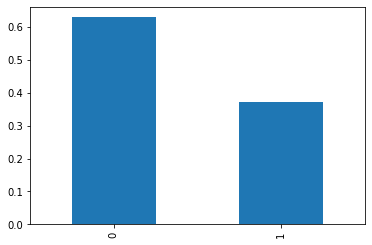

In [11]:
#How many data points for each class are present#
## balanced-dataset vs imbalanced datasets#
print(df_train.is_duplicate.value_counts()) # Question pairs are not Similar (is_duplicate = 0)
print(df_train.is_duplicate.value_counts(normalize=True)) # Question pairs are Similar (is_duplicate = 1)
plt.show(df_train.is_duplicate.value_counts(normalize=True).plot.bar()) #D istribution of data points among output classes 

In [12]:
#Checking whether there are any rows with null values
nan_rows = df_train[df_train.isnull().any(1)]
print (nan_rows) 

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [13]:
# Filling the null values with ' '
df_train = df_train.fillna('')
nan_rows = df_train[df_train.isnull().any(1)]
print (nan_rows) 

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [0]:
def Basic_Feature_Extraction(df):
  df['len_q1'] = df.question1.apply(lambda x: len(str(x))) # Length of question1 
  df['len_q2'] = df.question2.apply(lambda x: len(str(x))) # Length of question2
  df['diff len'] = abs(df.len_q1- df.len_q2)       # Difference in the two lengths
  df['len_char_ql'] = df.question1.apply(lambda x: len(''.join(set(str(x).replace('', ''))))) #Character length of question1 without spaces
  df['len_char_q2'] = df.question2.apply(lambda x: len(''.join(set(str(x).replace('', ''))))) #Character length of question2 without spaces
  df['len_word_q1'] = df.question1.apply(lambda x: len(str(x).split())) # Number of words in question1
  df['len_word_q2'] = df.question2.apply(lambda x: len(str(x).split())) # Number of words in question2
  df['common_words'] =df.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))),axis=1)# Number of common words in question1 and question2
  df['word_share']  = df.common_words/(df.len_word_q1+df.len_word_q2) #(word_common)/(total number of words) 
  return df

In [0]:
df_train= Basic_Feature_Extraction(df_train) # Basic Feature Extraction (before cleaning) on train data set.

In [0]:
def decontracted(text):
    # general
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"what's", "", text)
    text = re.sub(r"What's", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"60k", " 60000 ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"quikly", "quickly", text)
    text = re.sub(r" usa ", " America ", text)
    text = re.sub(r" USA ", " America ", text)
    text = re.sub(r" u s ", " America ", text)
    text = re.sub(r" uk ", " England ", text)
    text = re.sub(r" UK ", " England ", text)
    text = re.sub(r"india", "India", text)
    text = re.sub(r"switzerland", "Switzerland", text)
    text = re.sub(r"china", "China", text)
    text = re.sub(r"chinese", "Chinese", text) 
    text = re.sub(r"imrovement", "improvement", text)
    text = re.sub(r"intially", "initially", text)
    text = re.sub(r"quora", "Quora", text)
    text = re.sub(r" dms ", "direct messages ", text)  
    text = re.sub(r"demonitization", "demonetization", text) 
    text = re.sub(r"actived", "active", text)
    text = re.sub(r"kms", " kilometers ", text)
    text = re.sub(r"KMs", " kilometers ", text)
    text = re.sub(r" cs ", " computer science ", text) 
    text = re.sub(r" upvotes ", " up votes ", text)
    text = re.sub(r" iPhone ", " phone ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r"calender", "calendar", text)
    text = re.sub(r"ios", "operating system", text)
    text = re.sub(r"gps", "GPS", text)
    text = re.sub(r"gst", "GST", text)
    text = re.sub(r"programing", "programming", text)
    text = re.sub(r"bestfriend", "best friend", text)
    text = re.sub(r"dna", "DNA", text)
    text = re.sub(r"III", "3", text) 
    text = re.sub(r"the US", "America", text)
    text = re.sub(r"Astrology", "astrology", text)
    text = re.sub(r"Method", "method", text)
    text = re.sub(r"Find", "find", text) 
    text = re.sub(r"banglore", "Banglore", text)
    text = re.sub(r" J K ", " JK ", text)
    return text 
def clean_text(text):
  text = text.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
  .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
  .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
  .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
  .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
  .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
  .replace("€", " euro ").replace("'ll", " will")
  text=  decontracted(text)
  text = re.sub("\S*\d\S*", "", text).strip()
  text = re.sub('[^A-Za-z]+', ' ', text)
  text= re.sub(r"http\S+", "", text)
  return text

In [0]:
def preprocess(x):
    porter = PorterStemmer() 
    pattern = re.compile('\W') 
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)

    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
    return x 

STOP_WORDS = stopwords.words("english")
SAFE_DIV = 0.0001 

In [0]:
df_train['clean_q1']= df_train['question1'].apply(lambda x: clean_text(x)) 
df_train['clean_q2']= df_train['question2'].apply(lambda x: clean_text(x)) 

In [0]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df


In [21]:
df_train= extract_features(df_train)

token features...
fuzzy features..


In [22]:
df_train.head() 

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,diff len,len_char_ql,len_char_q2,len_word_q1,len_word_q2,common_words,word_share,clean_q1,clean_q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0,34,34,0,22,21,8,8,7,0.437500,How do I play Pok mon GO in Korea,How do I play Pok mon GO in China,0.749981,0.749981,0.999975,0.999975,0.874989,0.874989,0.0,1.0,0.0,8.0,90,81,88,88,0.800000
368101,368101,12736,104117,what are some of the best side dishes for crab...,what are some good side dishes for buffalo chi...,0,53,51,2,17,21,11,9,6,0.300000,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0.399992,0.399992,0.999975,0.666656,0.666659,0.545450,0.0,1.0,2.0,10.0,73,73,73,73,0.326923
70497,70497,121486,121487,which is more advisable and better material fo...,what is the best server setup for buddypress,0,96,45,51,21,18,16,8,2,0.083333,Which is more advisable and better material fo...,What is the best server setup for buddypress,0.000000,0.000000,0.499988,0.249997,0.249997,0.124999,0.0,0.0,8.0,12.0,24,36,35,44,0.108696
226567,226567,254474,258192,how do i improve logical programming skills,how can i improve my logical skills for progra...,1,44,52,8,20,21,7,9,4,0.250000,How do I improve logical programming skills,How can I improve my logical skills for progra...,0.999975,0.999975,0.666644,0.399992,0.857131,0.666659,0.0,1.0,2.0,8.0,96,89,72,68,0.288889
73186,73186,48103,3062,how close we are to see 3rd world war,how close is a world war iii,1,38,29,9,14,15,9,7,3,0.187500,How close we are to see world war,How close is a World War,0.749981,0.599988,0.333322,0.249994,0.571420,0.444440,0.0,1.0,2.0,8.0,81,71,68,62,0.366667


In [0]:
# the data we want to predict 
X= df_train.drop(['is_duplicate'],axis=1)
Y= df_train['is_duplicate'] 

In [24]:
from sklearn.model_selection import train_test_split 
# split X and y into training and testing sets 
X_train,X_test,y_train,y_test = train_test_split(X,Y,shuffle=True,test_size=0.30,random_state=42) 
print(X_train.shape, y_train.shape,X_test.shape,y_test.shape)

(70000, 31) (70000,) (30000, 31) (30000,)


In [0]:
# finding TFIDF for question 1
tfidf = TfidfVectorizer(min_df=10, max_features =None, strip_accents='unicode', analyzer = 'word', token_pattern= r'\w{1,}', ngram_range= (1,2), use_idf= 1, smooth_idf= 1, sublinear_tf= 1, stop_words= 'english',lowercase=True)

In [0]:
X_train_q1 = tfidf.fit_transform(list(X_train.clean_q1))
X_test_q1 =  tfidf.transform(list(X_test.clean_q1))

from sklearn.preprocessing import StandardScaler
sc= StandardScaler(with_mean=False) 
X_train_q1 = sc.fit_transform(X_train_q1)
X_test_q1 =  sc.transform(X_test_q1) 

In [0]:
X_train_q2 = tfidf.fit_transform(list(X_train.clean_q2)) 
X_train_q2 = sc.fit_transform(X_train_q2) 
X_test_q2 =  tfidf.transform(list(X_test.clean_q2))
X_test_q2 =  sc.transform(X_test_q2) 

In [0]:
# Train your own Word2Vec model using your own text corpus
import nltk
T_list_q1=X_train['clean_q1'].values.tolist()
T_list_q2=X_train['clean_q2'].values.tolist()
train_corpus= T_list_q1+ T_list_q2
words_train = [nltk.word_tokenize(q) for q in train_corpus] 

In [0]:
# Train your own Word2Vec model using your own text corpus

T_list_q1=X_test['clean_q1'].values.tolist()
T_list_q2=X_test['clean_q2'].values.tolist()
test_corpus= T_list_q1+ T_list_q2
words_test = [nltk.word_tokenize(q) for q in test_corpus] 

In [0]:
# this line of code trains your w2v model on the give list of sentances
w2v_model_train=Word2Vec(words_train,min_count=5,size=50, workers=4) 
w2v_model_test= Word2Vec(words_test,min_count=5,size=50, workers=4) 

In [0]:
def tfidf_w2v (a,b,c):
  tfidf_feat = tfidf.get_feature_names() # tfidf words/col-names
  tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
  row=0;
  for sent in tqdm(list(a)): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = c.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = b[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf) 
            weight_sum += tf_idf 
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
  tfidfw2v = np.nan_to_num(tfidf_sent_vectors) 
  return tfidfw2v

In [32]:
tfidfw2v_train_q1= tfidf_w2v(X_train['clean_q1'],X_train_q1,w2v_model_train) 
tfidfw2v_train_q2= tfidf_w2v(X_train['clean_q2'],X_train_q2,w2v_model_train)
tfidfw2v_test_q1= tfidf_w2v(X_test['clean_q1'],X_test_q1,w2v_model_test) 
tfidfw2v_test_q2= tfidf_w2v(X_test['clean_q2'],X_test_q2,w2v_model_test)   

100%|██████████| 30000/30000 [03:33<00:00, 140.43it/s]


In [0]:
tfidfw2v_train_q1_sc= sc.fit_transform(tfidfw2v_train_q1) 
tfidfw2v_train_q2_sc= sc.fit_transform(tfidfw2v_train_q2) 
tfidfw2v_test_q1_sc= sc.transform(tfidfw2v_test_q1)
tfidfw2v_test_q2_sc= sc.transform(tfidfw2v_test_q2) 

In [0]:
X_train = X_train.drop(['id','qid1','qid2','question1','question2','clean_q1','clean_q2'], axis= 1)
X_test =  X_test.drop(['id','qid1','qid2','question1','question2','clean_q1','clean_q2'], axis= 1) 

In [0]:
from sklearn.preprocessing import StandardScaler
sc= StandardScaler(with_mean=False) 
X_train = sc.fit_transform(X_train) 
X_test =  sc.transform(X_test) 

In [0]:
X_train_tfidf_w2v = np.hstack((X_train,tfidfw2v_train_q1_sc,tfidfw2v_train_q2_sc)) 
X_test_tfidf_w2v  = np.hstack((X_test,tfidfw2v_test_q1_sc,tfidfw2v_test_q2_sc)) 

In [0]:
X_train = hstack((X_train,X_train_q1,X_train_q2)) 
X_test =  hstack((X_test, X_test_q1,X_test_q2)) 

In [38]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train) 
train_len = len(y_train) 
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6290285714285714 Class 1:  0.37097142857142856
---------- Distribution of output variable in train data ----------
Class 0:  0.3717666666666667 Class 1:  0.3717666666666667


In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

**Building a random model (Finding worst-case log-loss)**

Log loss on Test Data using Random Model 0.8857578623028591


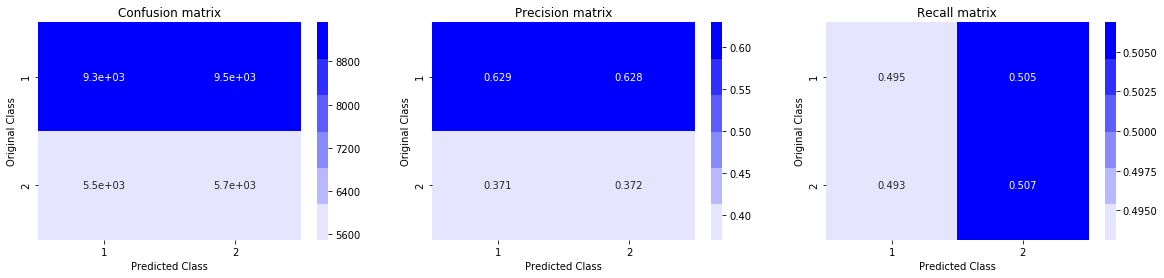

In [40]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

**Logistic Regression with hyperparameter tuning**

For values of alpha =  1e-05 The log loss is: 0.5138774071362696
For values of alpha =  0.0001 The log loss is: 0.5082448029462147
For values of alpha =  0.001 The log loss is: 0.4869488918271431
For values of alpha =  0.01 The log loss is: 0.4649352872738495
For values of alpha =  0.1 The log loss is: 0.4476597384429026
For values of alpha =  1 The log loss is: 0.4563850271193639
For values of alpha =  10 The log loss is: 0.47412233856321273


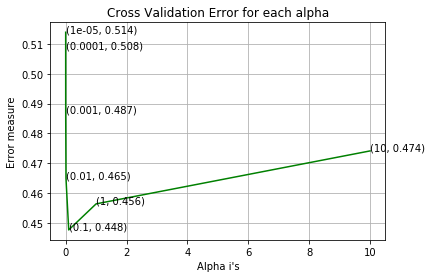

For values of best alpha =  0.1 The train log loss is: 0.3661226605933786
For values of best alpha =  0.1 The test log loss is: 0.4503588567363775
Total number of data points : 30000


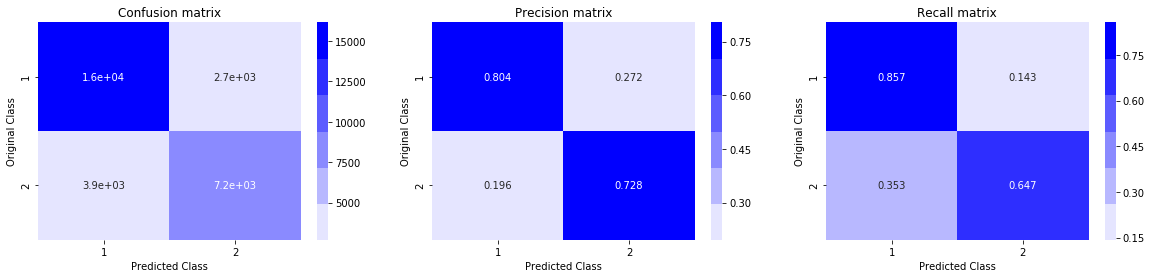

In [41]:
from sklearn.linear_model import SGDClassifier
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#-----------------------------
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', class_weight='balanced',random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid",cv=5)
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

**Linear SVM with hyperparameter tuning**

For values of alpha =  1e-05 The log loss is: 0.6598905325443313
For values of alpha =  0.0001 The log loss is: 0.6598905325443313
For values of alpha =  0.001 The log loss is: 0.6598905325443313
For values of alpha =  0.01 The log loss is: 0.6598905325443313
For values of alpha =  0.1 The log loss is: 0.6598499750361805
For values of alpha =  1 The log loss is: 0.6598636495176057
For values of alpha =  10 The log loss is: 0.6598771510927542


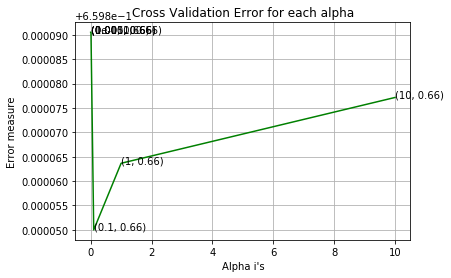

For values of best alpha =  0.1 The train log loss is: 0.6594706685776326
For values of best alpha =  0.1 The test log loss is: 0.6598905325443313
Total number of data points : 30000


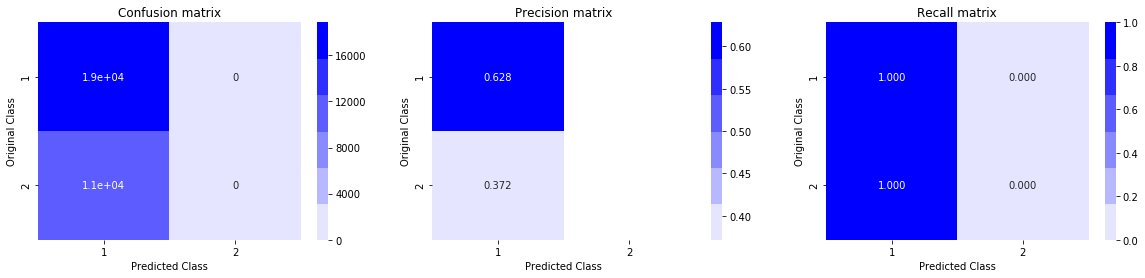

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge',class_weight='balanced', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf,method="sigmoid")  
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

**XGBoost with hyperparameter tuning**

In [0]:
import xgboost as xgb
estimators = [55, 89, 144, 233, 377, 610,987]
tree_depth = [1, 2, 3, 5, 8, 13, 21] 
clf_xgb = xgb.XGBClassifier() 
param_grid = {'n_estimators': estimators,'max_depth': tree_depth} 
grid = GridSearchCV(clf_xgb, param_grid, cv=3 , scoring ='neg_log_loss', n_jobs=-1,return_train_score=True)
grid.fit(X_train,y_train) 

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 5, 8, 13, 21],
                         'n_estimators': [55, 89, 144, 233, 377, 610, 987]},
             pre_dispatch='2*n_jobs', r

Best HyperParameter:  {'max_depth': 8, 'n_estimators': 144}
-0.42960331221484527


Text(51.0, 0.5, 'max_depth')

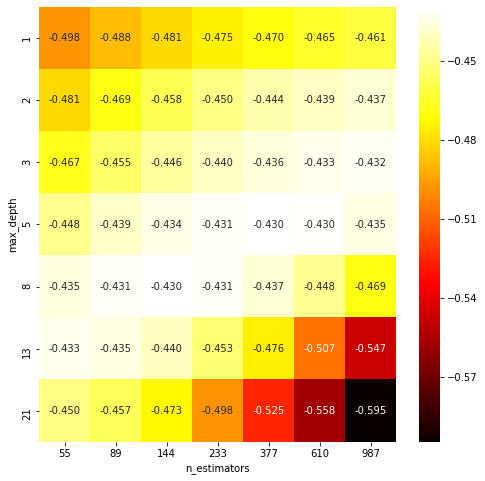

In [0]:
print("Best HyperParameter: ",grid.best_params_)
print(grid.best_score_) 
cv_auc = grid.cv_results_['mean_test_score'].reshape(len(estimators),len(tree_depth))
plt.figure(figsize=(8, 8)) 
sns.heatmap(cv_auc, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=estimators, yticklabels=tree_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')

Train log loss =  0.022732658011138027
Test log loss =  0.5093022041754344


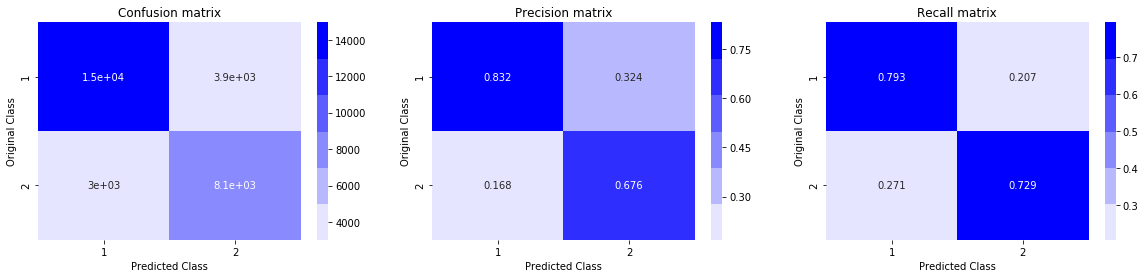

In [0]:
clf=xgb.XGBClassifier(n_jobs=-1,random_state=25,max_depth=13,n_estimators=987)
clf.fit(X_train,y_train) 
y_pred_test=clf.predict_proba(X_test) 
y_pred_train=clf.predict_proba(X_train)
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss = ',log_loss_train)
print('Test log loss = ',log_loss_test) 
predicted_y=np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(y_test,predicted_y)
 

**XGBoost with hyperparameter tuning on TFIDF_W2V**

In [46]:
import xgboost as xgb
estimators = [5, 10, 50, 100, 200,300,400]
tree_depth = [2, 3, 4, 5, 6, 7, 8]
clf_xgb = xgb.XGBClassifier() 
param_grid = {'n_estimators': estimators,'max_depth': tree_depth} 
grid = GridSearchCV(clf_xgb, param_grid, cv=3 , scoring ='neg_log_loss', n_jobs=-1,return_train_score=True)
grid.fit(X_train_tfidf_w2v,y_train) 

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'n_estimators': [5, 10, 50, 100, 200, 300, 400]},
             pre_dispatch='2*n_jobs', refit

Best HyperParameter:  {'max_depth': 7, 'n_estimators': 200}
-0.4296016093670254


Text(51.0, 0.5, 'max_depth')

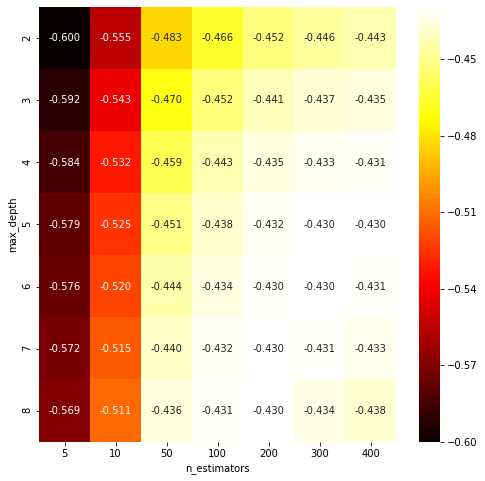

In [47]:
print("Best HyperParameter: ",grid.best_params_)
print(grid.best_score_) 
cv_auc = grid.cv_results_['mean_test_score'].reshape(len(estimators),len(tree_depth))
plt.figure(figsize=(8, 8)) 
sns.heatmap(cv_auc, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=estimators, yticklabels=tree_depth)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')

Train log loss =  0.022732657914710984
Test log loss =  0.5093022027168765


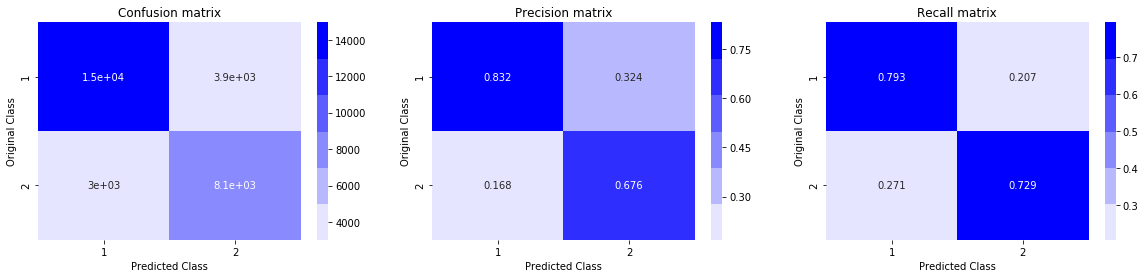

In [48]:
clf=xgb.XGBClassifier(n_jobs=-1,random_state=25,max_depth=13,n_estimators=987)
clf.fit(X_train_tfidf_w2v,y_train) 
y_pred_test=clf.predict_proba(X_test_tfidf_w2v) 
y_pred_train=clf.predict_proba(X_train_tfidf_w2v)
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss = ',log_loss_train)
print('Test log loss = ',log_loss_test) 
predicted_y=np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(y_test,predicted_y)

In [50]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable    
x = PrettyTable() 
x.field_names = ["Model","Vectorizer","optimal max_depth/alpha", "optimal n_estimators", "train_logloss",'test_logloss'] 
x.add_row(['Logistic Regression','BF+AF+TFIDF','0.1', '-', '0.366463', '0.45035'])
x.add_row(['Linear SVM','BF+AF+TFIDF','0.1', '-', '0.6594', '0.6598905'])  
x.add_row(['XGBOOST GBDT','BF+AF+TFIDF','8','144','0.0227','0.50930']) 
x.add_row(['XGBOOST GBDT','BF+AF+TFIDF_w2w','7','200','0.0227326','0.50930']) 
print(x) 

+---------------------+-----------------+-------------------------+----------------------+---------------+--------------+
|        Model        |    Vectorizer   | optimal max_depth/alpha | optimal n_estimators | train_logloss | test_logloss |
+---------------------+-----------------+-------------------------+----------------------+---------------+--------------+
| Logistic Regression |   BF+AF+TFIDF   |           0.1           |          -           |    0.366463   |   0.45035    |
|      Linear SVM     |   BF+AF+TFIDF   |           0.1           |          -           |     0.6594    |  0.6598905   |
|     XGBOOST GBDT    |   BF+AF+TFIDF   |            8            |         144          |     0.0227    |   0.50930    |
|     XGBOOST GBDT    | BF+AF+TFIDF_w2w |            7            |         200          |   0.0227326   |   0.50930    |
+---------------------+-----------------+-------------------------+----------------------+---------------+--------------+
